In [104]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.dates as mdates
import matplotlib.patches as mpatches
import matplotlib.colors as mcolors
import cartopy.crs as ccrs
from openpyxl import load_workbook
#from shapely.geometry import Point, LineString
#import shapely, shapely.prepared

In [105]:
red1 = '#891D2D'
red2 = '#BA3B31'
orange = '#F58221'
yellow = '#FCAF19'
brown = '#440A15'
brown2 = '#B45419'
purple1 = '#3B1053'
purple2 = '#76518E'
purple3 = '#B69DC7'
teal1 = '#032838'
teal2 = '#154655'
teal3 = '#527D77'
teal4 = '#8DB5AF'
teal1 = '#294839'
green1 = '#6DA08C'
green2 = '#6E966E'
green3 = '#A3BDA3'
beige1 = '#7A693B'
beige2 = '#A89677'
beige3 = '#D2CDAD'
grey1 = '#E7E7E7'
grey2 = '#D7D7D7'
grey3 = '#C6C6C6'
grey4 = '#939393'
blue1 = '#3EA1C0'

In [127]:
Horizon = 2040
start_year = 2025
discountrate = 0.04
NoOfPeakSeason = 2
lengthPeakSeason = 24
NoOfRegSeason = 4
lengthRegSeason = 168
LeapYearsInvestment = 3
season_scale = [(8760 - NoOfPeakSeason * lengthPeakSeason) / NoOfRegSeason / lengthRegSeason
                            for x in range(NoOfRegSeason)] + [1 for x in range(NoOfPeakSeason)]
new_names = ['CCGT',   'OCGT',  'Biomass',  'Oil'  ,'Wind', 'Solar', 'Hydro ror', 'Hydro storage', 'Geothermal']
new_names_2 = ['CCGT',   'OCGT',  'Biomass',  'Oil'  ,'Wind', 'Solar', 'Hydro', 'Geothermal']
old_names = ['Gas CCGT',    'Gas OCGT',  'Bio',   'Oil existing',  'Wind onshore',  'Solar'  ,'Hydro run-of-the-river', 'Hydro regulated', 'Geo']
scenario = '1'
date = '0513'
time = '1124'

file_path = 'Results/bolivia_v1_reg' + str(lengthRegSeason) + '_peak24_sce' + scenario + '_randomSGR_2024' + date + time + '/results_output_EuropePlot.csv'
operational_data = pd.read_csv('Results/bolivia_v1_reg' + str(lengthRegSeason) + '_peak24_sce' + scenario + '_randomSGR_2024' + date + time +'/results_output_Operational.csv')
investment_data = pd.read_csv('Results/bolivia_v1_reg' + str(lengthRegSeason) + '_peak24_sce' + scenario + '_randomSGR_2024' + date + time +'/results_output_gen.csv')
objective_value = pd.read_csv('Results/bolivia_v1_reg' + str(lengthRegSeason) + '_peak24_sce' + scenario + '_randomSGR_2024' + date + time +'/results_objective.csv', header=None)
transmission_data = pd.read_csv('Results/bolivia_v1_reg' + str(lengthRegSeason) + '_peak24_sce' + scenario + '_randomSGR_2024' + date + time +'/results_output_transmision.csv')
stor_data = pd.read_csv('Results/bolivia_v1_reg' + str(lengthRegSeason) + '_peak24_sce' + scenario + '_randomSGR_2024' + date + time +'/results_output_stor.csv')
node_sheet = load_workbook('Data handler/bolivia_v1/Node.xlsx')

scenario_int = int(scenario)
prob_scenarios = {f"scenario{i}": 1/scenario_int for i in range(1,scenario_int+1)}
regular_seasons = ['winter', 'spring', 'summer', 'fall']
peak_seasons = ['peak1', 'peak2']

total_periods = int((Horizon - start_year)/LeapYearsInvestment)

In [128]:
# Helper functions
def get_colors(carriers):
    colors = [beige2, beige3, teal3, beige1, teal4, yellow, teal2, brown2]
    color_dict = dict(zip(new_names_2, colors))
    colors_new = [color_dict[carrier] for carrier in carriers]
    return colors_new

def rename_columns(df):
    old_names_no_space = [names.replace(" ", "") for names in old_names]
    name_map= dict(zip(old_names_no_space, new_names))
    df = df.rename(columns=name_map)
    return df

def open_csv(file, included_rows):
    data_list = []
    with open(file, 'r') as f:
        next(f)
        headers = f.readline().strip().split(',')  # Read the first line to get headers
        for i, line in enumerate(f, start=2):  # Start counting from 2 since headers are at line 1
            if i in included_rows:
                # Split the line by comma, or change delimiter as necessary
                values = line.strip().split(',')
                # Create a dictionary for the row using a dictionary comprehension and zip to pair headers and values
                row_data = dict(zip(headers, values))
                data_list.append(row_data)
    return pd.DataFrame(data_list)

def rename_columns_operations(df):
    operations_names = ['GasCCGT_MW', 'GasOCGT_MW', 'Bio_MW', 'Oilexisting_MW', 'Windonshore_MW', 'Solar_MW', 'Hydrorun-of-the-river_MW', 'Hydroregulated_MW', 'Geo_MW']
    name_map= dict(zip(operations_names, new_names))
    df = df.rename(columns=name_map)
    return df

def custom_autopct(pct):
    return ('%1.1f%%' % pct)# if pct > 0 else ''

def get_marginal_cost(technology):
    generator_file = load_workbook('Data handler/bolivia_v1/Generator.xlsx')
    generator_efficiency = generator_file['Efficiency']
    generator_VOM = generator_file['VariableOMCosts']
    generator_fuel_cost = generator_file['FuelCosts']

    for row in range(2, generator_efficiency.max_row + 1):  
        if generator_efficiency.cell(row, 1).value == technology:
            efficiency = generator_efficiency.cell(row, 3).value  
            break  

    for row in range(2, generator_VOM.max_row + 1):
        if generator_VOM.cell(row, 1).value == technology:
            VOM = generator_VOM.cell(row, 2).value 
            break

    for row in range(2, generator_fuel_cost.max_row + 1):
        if generator_fuel_cost.cell(row, 1).value == technology:
            fuel_cost = generator_fuel_cost.cell(row, 3).value 
            break
        
    return (3.6/efficiency)*fuel_cost + VOM

def get_period(year):
    return (year - start_year) // LeapYearsInvestment


           Hydro storage   Hydro ror    OCGT  Biomass     CCGT   Oil  \
                                                                       
Initial           368.58  363.720000  425.95   127.72  1343.07  8.66   
2025-2030         368.58  363.720000  425.95   127.72  1343.07  8.66   
2030-2035         356.15  351.907699  340.92   106.72  1343.07  6.46   
2035-2040         356.15  356.573572  235.71   840.00  1343.07  5.18   

                 Wind        Solar    Geothermal  
                                                  
Initial    131.400000   165.080000  0.000000e+00  
2025-2030  131.400000   165.080000  1.544116e-13  
2030-2035   27.000000  1178.179135  5.100000e+02  
2035-2040  515.420577  1522.371156  5.100000e+02  


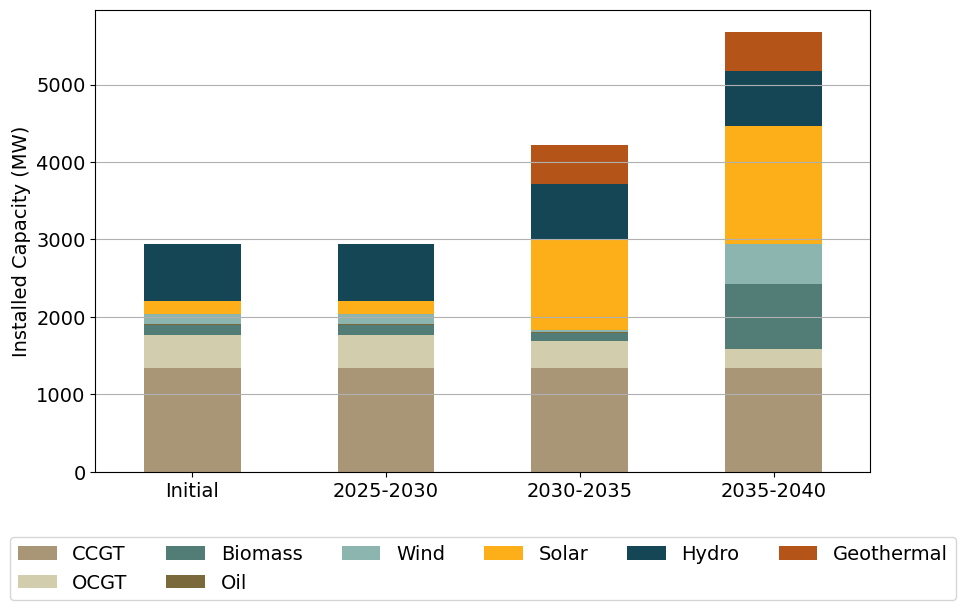

              CCGT    OCGT  Biomass   Oil        Wind        Solar  \
                                                                     
Initial    1343.07  425.95   127.72  8.66  131.400000   165.080000   
2025-2030  1343.07  425.95   127.72  8.66  131.400000   165.080000   
2030-2035  1343.07  340.92   106.72  6.46   27.000000  1178.179135   
2035-2040  1343.07  235.71   840.00  5.18  515.420577  1522.371156   

                Hydro    Geothermal  
                                     
Initial    732.300000  0.000000e+00  
2025-2030  732.300000  1.544116e-13  
2030-2035  708.057699  5.100000e+02  
2035-2040  712.723572  5.100000e+02  


[0, 1, 2, 3, 4, 5]

In [137]:

included_rows_installed_cap = [i for i in range(total_periods + 1)]
#included_rows = [2,3,4,5,6,7]
installed_cap = open_csv(file_path, included_rows_installed_cap)
installed_cap.set_index('', inplace=True)

for column in installed_cap.columns:
    installed_cap[column] = pd.to_numeric(installed_cap[column], errors='coerce')

installed_cap = rename_columns(installed_cap)
print(installed_cap)
installed_cap['Hydro'] = installed_cap['Hydro ror'] + installed_cap['Hydro storage']
installed_cap.drop(columns=['Hydro ror', 'Hydro storage'], inplace=True)
installed_cap = installed_cap[['CCGT', 'OCGT', 'Biomass', 'Oil', 'Wind', 'Solar', 'Hydro', 'Geothermal']]
installed_cap.plot(kind='bar', stacked=True, figsize=(10, 6), color=get_colors(installed_cap.columns))

# Adding titles and labels
plt.ylabel('Installed Capacity (MW)', fontsize=14)
plt.xticks(rotation = 0, fontsize=14)
plt.yticks(fontsize=14)
plt.grid(axis='y')
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.12), ncol=6, fontsize=14)
plt.savefig('figures/InstalledCapacity.png', bbox_inches='tight')
plt.show()

print(installed_cap)
included_rows_installed_cap

In [130]:
period_intervals = installed_cap.transpose().columns[1:]
period_intervals

Index(['2025-2030', '2030-2035', '2035-2040', '""', 'Period'], dtype='object', name='')

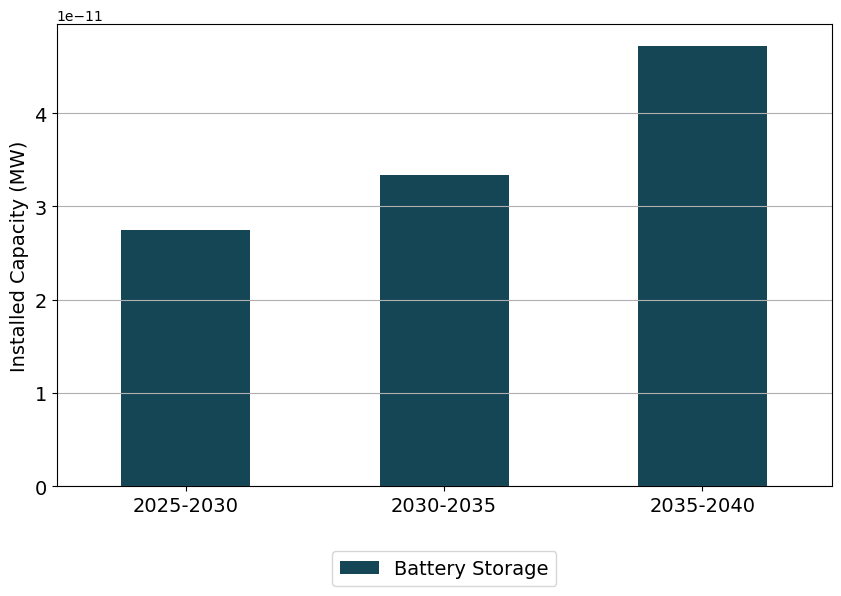

In [131]:
included_rows = [21, 22, 23]

installed_battery = open_csv(file_path, included_rows)
installed_battery.set_index('', inplace=True)

for column in installed_battery.columns:
    installed_battery[column] = pd.to_numeric(installed_battery[column], errors='coerce')

installed_battery.plot(kind='bar', stacked=True, figsize=(10, 6), color=teal2)

# Adding titles and labels
plt.ylabel('Installed Capacity (MW)', fontsize=14)
plt.xticks(rotation = 0, fontsize=14)
plt.yticks(fontsize=14)
plt.grid(axis='y')
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.12), ncol=6, fontsize=14, labels=['Battery Storage'])
plt.savefig('figures/InstalledCapacity.png', bbox_inches='tight')
plt.show()

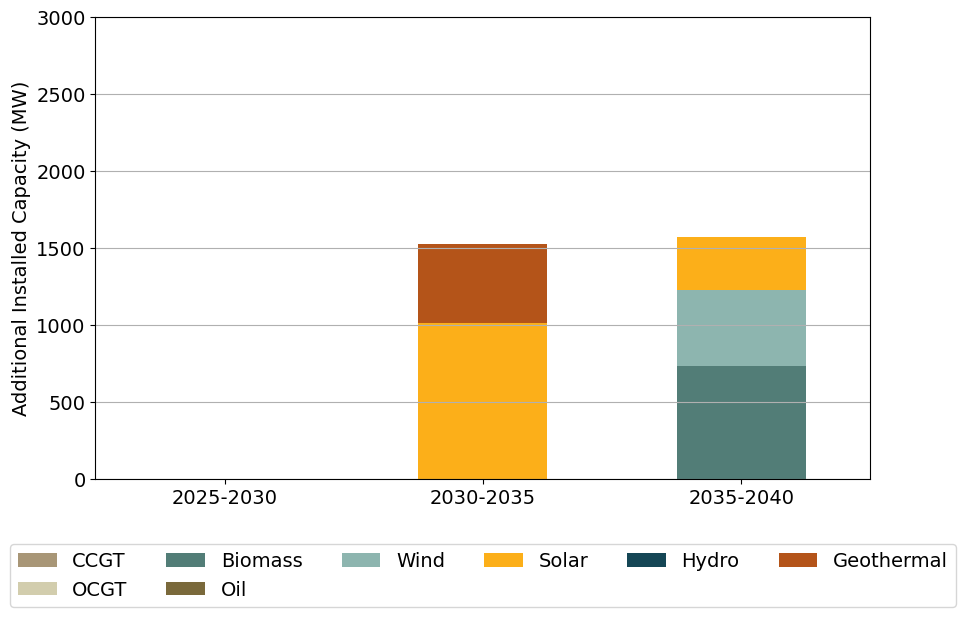

CCGT             0.000000
OCGT          -190.240000
Biomass        712.280000
Oil             -3.480000
Wind           384.020577
Solar         1357.291156
Hydro          -19.576428
Geothermal     510.000000
dtype: float64


In [132]:
# New installed capacity
new_installed_cap = installed_cap.diff()
new_installed_cap = rename_columns(new_installed_cap)
# new_installed_cap['Hydro'] = new_installed_cap['Hydro ror'] + new_installed_cap['Hydro storage']
# new_installed_cap.drop(columns=['Hydro ror', 'Hydro storage'], inplace=True)
new_installed_cap = new_installed_cap.dropna()
new_installed_cap.plot(kind='bar', stacked=True, figsize=(10, 6), color=get_colors(installed_cap.columns))

plt.ylabel('Additional Installed Capacity (MW)', fontsize=14)
plt.xticks(rotation = 0, fontsize=14)
plt.yticks(fontsize=14)
plt.grid(axis='y')
plt.ylim(0, 3000)
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.12), ncol=6, fontsize=14)
plt.savefig('figures/NewInstalledCapacity.png', bbox_inches='tight')
plt.show()

print(new_installed_cap.sum(    ))  

In [133]:
included_rows_installed_cap[-1]

7

[9, 10, 11]

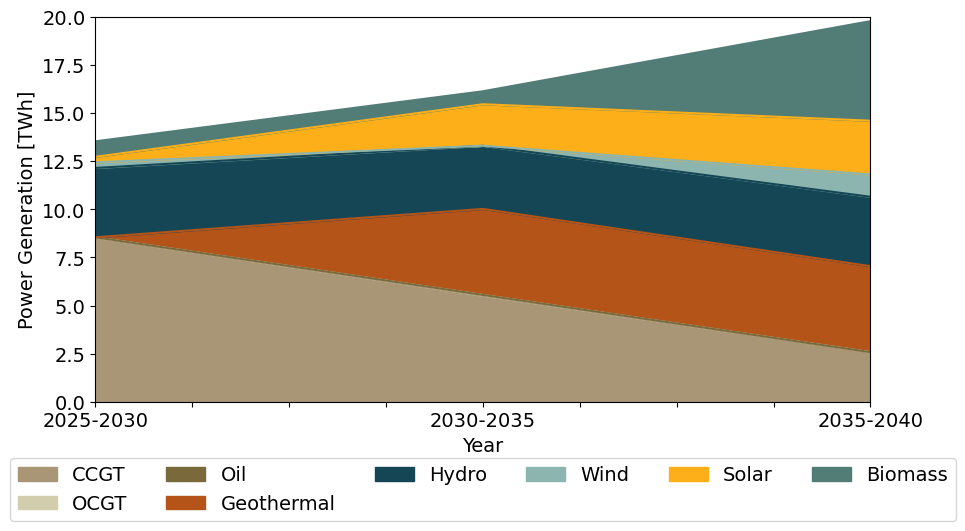

In [142]:
included_rows_dispatch = [9,10,11]

#included_rows_dispatch = [(included_rows_installed_cap[-1] + i) for i in range(total_periods)]

dispatch = open_csv(file_path, included_rows_dispatch)
dispatch.set_index('', inplace=True)
for column in dispatch.columns:
    dispatch[column] = pd.to_numeric(dispatch[column], errors='coerce')

dispatch = rename_columns(dispatch)

dispatch /= 1000
dispatch['Hydro'] = dispatch['Hydro ror'] + dispatch['Hydro storage']
dispatch.drop(columns=['Hydro ror', 'Hydro storage'], inplace=True)

# reorder columns to ['CCGT',   'OCGT',  'Oil',  'Geothermal' , 'Hydro', 'Wind', 'Solar',   'Biomass']
dispatch = dispatch[['CCGT', 'OCGT', 'Oil', 'Geothermal', 'Hydro', 'Wind', 'Solar', 'Biomass']]

production_plot = dispatch.plot.area(stacked=True, color=get_colors(dispatch.columns),figsize=(10, 5))
production_plot.set_xlim(0,total_periods-1)
plt.ylabel('Power Generation [TWh]', fontsize=14)
plt.xlabel('Year', fontsize=14)
plt.xticks(rotation = 0, fontsize=14)
plt.yticks(fontsize=14)
plt.ylim(0, 20)
plt.xlim(0,2)
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.12), ncol=6, fontsize=14)
plt.savefig('figures/Production.png', bbox_inches='tight')
included_rows_dispatch

C:\Users\marih\AppData\Local\Temp\ipykernel_7132\3763345479.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  snapshots.drop(columns=['Hydroregulated_MW'], inplace=True)


Empty DataFrame
Columns: [LoadShed_MW, storCharge_MW, Load_MW, GasCCGT_MW, GasOCGT_MW, Oilexisting_MW, Geo_MW, Hydrorun-of-the-river_MW, Windonshore_MW, Solar_MW, Bio_MW, storDischarge_MW]
Index: []


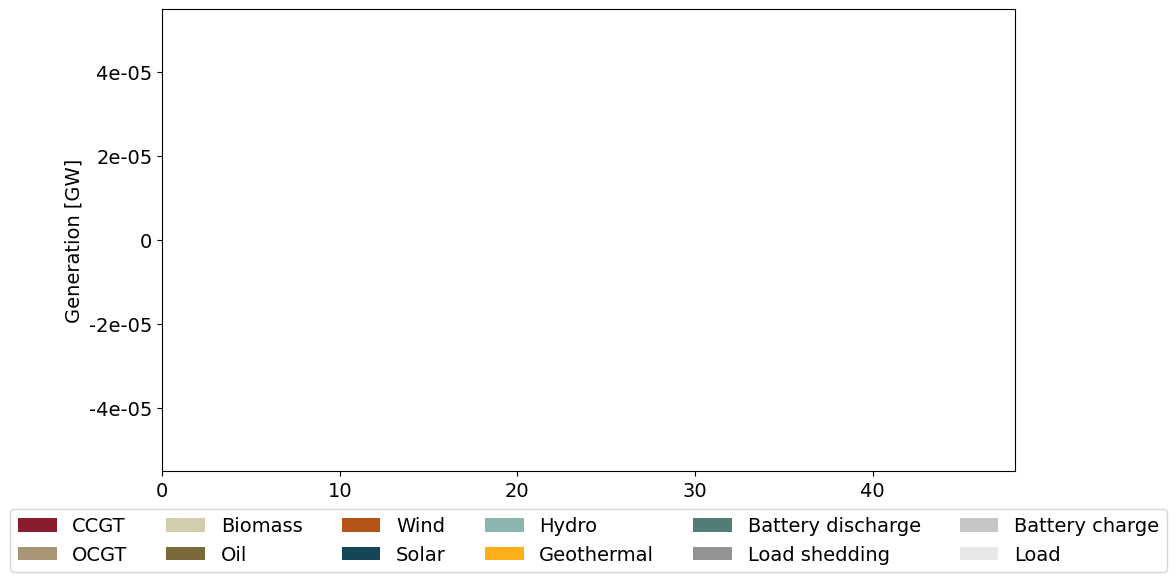

In [143]:
period = period_intervals[-1]
scenario_number = 'scenario1'

filtered_data = operational_data[(operational_data['Period'] == period) & (operational_data['Season'].isin(regular_seasons)) & (operational_data['Scenario'] == scenario_number)]
old_names_no_space = [names.replace(" ", "") for names in old_names]
snapshot_columns = [tech + '_MW' for tech in old_names_no_space]
snapshot_columns.append('storDischarge_MW')
snapshot_columns.append('storCharge_MW')
snapshot_columns.append('Hour')
snapshot_columns.append('Load_MW')
snapshot_columns.append('LoadShed_MW')
snapshots = filtered_data[snapshot_columns]
snapshots.loc[:,'Hydrorun-of-the-river_MW'] = snapshots['Hydrorun-of-the-river_MW'] + snapshots['Hydroregulated_MW']
snapshots.drop(columns=['Hydroregulated_MW'], inplace=True)

# Reorder columns to ['Hour', 'LoadShed_MW', 'storCharge_MW', 'storDischarge_MW', 'Load_MW', 'GasCCGT_MW', 'GasOCGT_MW', 'Oilexisting_MW', 'Geo_MW', 'Hydrorun-of-the-river_MW', 'Windonshore_MW', 'Solar_MW', 'Bio_MW']
snapshots = snapshots[['Hour', 'LoadShed_MW', 'storCharge_MW', 'Load_MW', 'GasCCGT_MW', 'GasOCGT_MW', 'Oilexisting_MW', 'Geo_MW', 'Hydrorun-of-the-river_MW', 'Windonshore_MW', 'Solar_MW', 'Bio_MW', 'storDischarge_MW']]

# Sum based on Hour and then plot aggregated snapshots
snapshots = snapshots.groupby('Hour').sum()
print(snapshots.head())
fig, ax=plt.subplots(figsize = (11,6))
columns_to_plot = [col for col in snapshots.columns if col not in ['Hour', 'storCharge_MW', 'Load_MW']]
#colors= [beige2, beige3, green2, beige1, teal4, yellow, teal2, brown2, grey4, red1]
colors = [red1, beige2, beige3, beige1, brown2, teal2, teal4, yellow, teal3, grey4]
dispatch_plot = plt.stackplot(snapshots.index, [snapshots[col] for col in columns_to_plot], colors=colors, zorder=2)
plt.stackplot(snapshots.index, snapshots['storCharge_MW'] + snapshots['Load_MW'], labels=['storCharge_MW'], colors=[grey3], zorder=2)
plt.stackplot(snapshots.index, snapshots['Load_MW'], labels=['Load'], colors=[grey1], zorder=2)
plt.xticks(rotation = 0, fontsize=14)
plt.yticks(fontsize=14)
scale_y = 1e3
ticks_y = ticker.FuncFormatter(lambda x, pos: '{0:g}'.format(x/scale_y))
ax.yaxis.set_major_formatter(ticks_y)
# myFmt = mdates.DateFormatter('%d %b')
# ax.xaxis.set_major_formatter(myFmt)
all_labels = new_names_2 + ['Battery discharge'] +['Load shedding'] + ['Battery charge'] + ['Load']
plt.legend(labels=all_labels,loc='upper center', bbox_to_anchor=(0.5, -0.06), ncol=6, fontsize=14)
ax.set_ylabel('Generation [GW]', fontsize=14)
ax.set_xlim(0, 24*2)

plt.savefig('figures/Dispatch.png', bbox_inches='tight')

In [136]:

dispatch_firstperiod = dispatch[:1][['CCGT', 'OCGT', 'Oil', 'Geothermal', 'Hydro', 'Wind', 'Solar', 'Biomass']]
dispatch_lastperiod = dispatch[-1:][['CCGT', 'OCGT', 'Oil', 'Geothermal', 'Hydro', 'Wind', 'Solar', 'Biomass']]
 
 
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
 
wedges1, texts1, autotexts1 = ax1.pie(
    dispatch_firstperiod.iloc[0].values, autopct=custom_autopct,
    colors=get_colors(dispatch_firstperiod.columns), startangle=90, counterclock=False,
    wedgeprops=dict(width=0.3), pctdistance=1.1
)
 
wedges2, texts2, autotexts2 = ax2.pie(
    dispatch_lastperiod.iloc[0].values, autopct=custom_autopct,
    colors=get_colors(dispatch_lastperiod.columns), startangle=90, counterclock=False,
    wedgeprops=dict(width=0.3), pctdistance=1.1
    
)
 
for autotext in autotexts1 + autotexts2:
    if autotext.get_text() <= '0.3%':
        autotext.set_visible(False)
 
centre_circle1 = plt.Circle((0,0),0.70,fc='white')
ax1.add_artist(centre_circle1)
ax1.set_title("2025 - 2030" +' Power Mix')
 
centre_circle2 = plt.Circle((0,0),0.70,fc='white')
ax2.add_artist(centre_circle2)
ax2.set_title("2035 - 2040" +' Power Mix')
 
ax1.axis('equal')
ax2.axis('equal')
 
fig.legend(dispatch_lastperiod.columns, loc="center right", bbox_to_anchor=(1.05, 0.5))
plt.tight_layout(pad=3.0)

o = dispatch_firstperiod["OCGT"].sum()

o/dispatch_firstperiod.sum().sum()



ValueError: cannot convert float NaN to integer

ValueError: need at least one array to concatenate

<Figure size 1200x500 with 2 Axes>

4044.939248329348


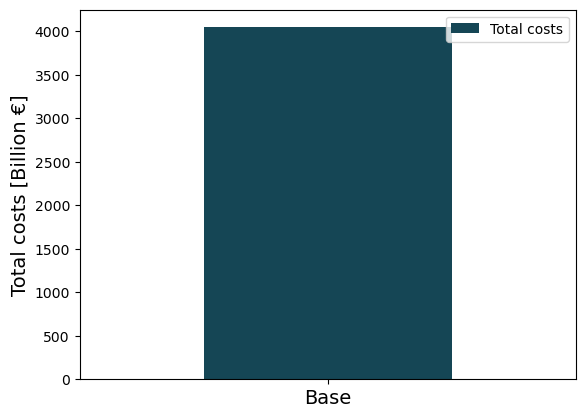

In [ ]:
total_costs = objective_value.iloc[0,1] /1e6
total_costs_df = pd.DataFrame(total_costs, index=['Base'],  columns=['Total costs'])
print(total_costs)
total_costs_df.plot(kind='bar', color=teal2)
plt.ylabel('Total costs [Billion €]', fontsize=14)
plt.xticks(rotation = 0, fontsize=14)

plt.show()

NPV:  3359.2474420560575


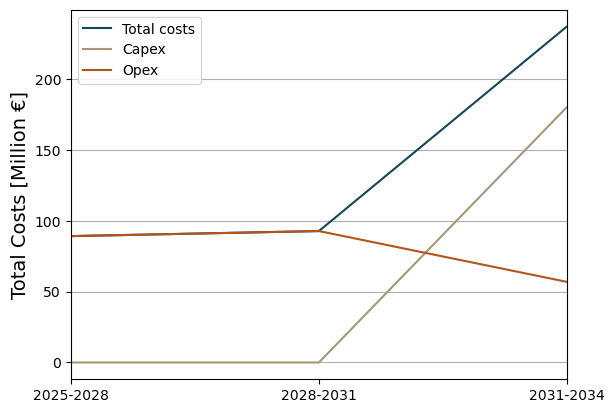

In [ ]:
periods = period_intervals
load_shed_cost = node_sheet['NodeLostLoadCost']['C4'].value
capex_dict = {}
for period in periods:
    sum_capex = (investment_data[(investment_data['Period'] == period)]['DiscountedInvestmentCost_Euro'].sum() 
                 + transmission_data[(transmission_data['Period'] == period)]['DiscountedInvestmentCost_EuroPerMW'].sum() 
                 + stor_data[(stor_data['Period'] == period)]['DiscountedInvestmentCostPWEN_EuroPerMWMWh'].sum())
    capex_dict[period] = sum_capex / 1e6 

capex = pd.DataFrame(list(capex_dict.items()), columns=['Period', 'TotalInvestment'])

operational_scalar = sum((1+discountrate)**(-j) for j in list(range(0,LeapYearsInvestment)))

opex_dict = {}
for period, num_period in zip(periods, range(1, len(periods) + 1)):
    sum_opex = 0
    coeff = 1
    if num_period > 1:
        coeff = pow(1.0 + discountrate, -LeapYearsInvestment * (num_period - 1))
    for i in range(scenario_int):
        for tech in old_names:
            tech_no_space = tech.replace(" ", "")
            generated = operational_data[(operational_data['Period'] == period) & (operational_data['Scenario'] == f'scenario{i+1}') & (operational_data['Season'].isin(regular_seasons))][tech_no_space + '_MW'].sum()
            generated_peak = operational_data[(operational_data['Period'] == period) & (operational_data['Scenario'] == f'scenario{i+1}') & (operational_data['Season'].isin(peak_seasons))][tech_no_space + '_MW'].sum()
            sum_opex += get_marginal_cost(tech) * (generated * season_scale[0] + generated_peak * season_scale[5]) * prob_scenarios[f'scenario{i+1}'] * coeff * operational_scalar 
        sum_opex += operational_data[(operational_data['Period'] == period) & (operational_data['Scenario'] == f'scenario{i+1}') & (operational_data['Season'].isin(regular_seasons))]['LoadShed_MW'].sum() * load_shed_cost * season_scale[0] * prob_scenarios[f'scenario{i+1}'] * coeff * operational_scalar
    
    opex_dict[period] = sum_opex / 1e6 # in billion euros

opex = pd.DataFrame(list(opex_dict.items()), columns=['Period', 'TotalOperationalCost'])
npv = capex['TotalInvestment'].sum() + opex['TotalOperationalCost'].sum()
print('NPV: ', npv)

total_costs = (capex['TotalInvestment'] + opex['TotalOperationalCost']) / 5
plt.plot(periods, total_costs, color=teal2, label ='Total costs')
plt.plot(periods, capex['TotalInvestment'] /5, color=beige2, label='Capex')
plt.plot(periods, opex['TotalOperationalCost'] /5, color=brown2, label = 'Opex')   
plt.ylabel('Total Costs [Million €]', fontsize=14)
plt.xlim(0,2)
#plt.ylim(0,300)
plt.grid(axis='y')
plt.legend()
plt.show()


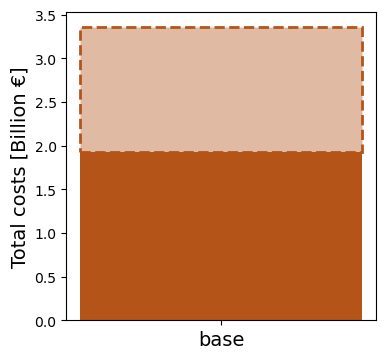

In [ ]:
capex_tot = capex['TotalInvestment'].sum() /1e3
opex_tot = opex['TotalOperationalCost'].sum() / 1e3
fig, ax = plt.subplots(figsize=(4, 4))
capex_bars = ax.bar('base', capex_tot, color=brown2)
fill_colors_with_alpha = [mcolors.to_rgba(brown2, alpha=0.4)]
solid_edge_colors = [mcolors.to_rgba(brown2, alpha=1)] 
opex_bars = ax.bar('base', opex_tot, bottom=capex_tot, color=fill_colors_with_alpha, edgecolor=solid_edge_colors, linestyle='--', linewidth=2)


plt.ylabel('Total costs [Billion €]', fontsize=14)
plt.xticks(rotation = 0, fontsize=14)

plt.show()

In [ ]:
# Read line capacity data from the transmission data
read_transmission_data = transmission_data[transmission_data['Period'].isin(periods)]

read_transmission_data['LineCapacity'] = transmission_data['transmissionInstalledCap_MW']

line_caps = read_transmission_data[['Period', 'LineCapacity']]

# Filter the data to only include the last period 2035-2040
line_caps_fin = line_caps[line_caps['Period'] == period_intervals[-1]]

# Filter the data to only include the capactiy of the lines
line_caps_fin = line_caps_fin[['LineCapacity']]

# Reset index and start the index from 1 instead of 0
line_caps_fin.reset_index(drop=True, inplace=True)
line_caps_fin.index += 1

# Rename index to Line 
line_caps_fin.index.name = 'Line'

# Drop the LineCapacity name, remove the naming completely
line_caps_fin.columns = ['s_nom_opt']

line_caps_fin

,s_nom_opt
Line,
1,644.400000
2,117.000000
3,117.000000
4,280.620000
5,864.270000
6,147.514351
7,497.250000
8,628.650000
9,293.400000


In [ ]:
# Change line_caps_fin to a Series like n.lines.s_nom_opt
line_caps_fin = line_caps_fin.squeeze()

# Change the dtype of the index to string
line_caps_fin.index = line_caps_fin.index.astype(str)

line_caps_fin

Line
1     644.400000
2     117.000000
3     117.000000
4     280.620000
5     864.270000
6     147.514351
7     497.250000
8     628.650000
9     293.400000
10    143.030133
11    126.000000
12    117.000000
13    130.632641
14    204.480000
15    158.220000
16    117.000000
17    117.000000
18    140.220000
19    299.397808
20    282.600000
21    117.000000
22    130.096554
23    117.000000
24    137.520000
25    300.150000
26    717.300000
27    117.000000
28    135.000000
29    288.000000
30    144.556040
31    300.150000
32    289.750498
33    117.000000
34    365.725463
35    128.250000
36    257.310000
37    117.000000
38    270.965057
39    117.000000
Name: s_nom_opt, dtype: float64

In [ ]:
gen_data = operational_data[(operational_data['Period'] == period_intervals[-1]) & (operational_data['Season'].isin(regular_seasons))]

gen_data = gen_data[['Node', 'Scenario', 'Season', 'AllGen_MW']]
# Change Node names from 'BO00' to 'BO0 0' format
gen_data['Node'] = gen_data['Node'].str.replace(r'(BO)(\d{1})', r'\1\2 ', regex=True)



# Sum the AllGen_MW in gen_data for all seasons and hours and then average the sums in all the scenarios for a node
gen_data_summed = gen_data.groupby(['Node', 'Scenario']).sum()

#gen_data_mean = gen_data_summed.groupby('Node').mean()
#gen_data_summed_series = gen_data_summed.squeeze()
#print(gen_data_summed_series)
#print(gen_data_summed_series.sum())


In [ ]:
period = period_intervals[-1]

gen_data_bus_reg = operational_data[(operational_data['Period'] == period) & (operational_data['Season'].isin(regular_seasons))]
gen_data_bus_reg = gen_data_bus_reg[['Node', 'Scenario', 'AllGen_MW']]
gen_data_bus_reg['Node'] = gen_data_bus_reg['Node'].str.replace(r'(BO)(\d{1})', r'\1\2 ', regex=True)
gen_data_bus_reg['AllGen_MW'] = gen_data_bus_reg['AllGen_MW'] * season_scale[0] 
# Multiply gen_data_bus_reg['AllGen_MW'] with the probability of the corresponding scenario
gen_data_bus_reg['AllGen_MW'] = gen_data_bus_reg['AllGen_MW'] * prob_scenarios[gen_data_bus_reg['Scenario'].values[0]]
gen_data_bus_reg = gen_data_bus_reg[['Node', 'AllGen_MW']]
gen_data_bus_reg = gen_data_bus_reg.groupby('Node').sum()

gen_data_bus_reg = gen_data_bus_reg.squeeze()
print(gen_data_bus_reg)
print(gen_data_bus_reg.sum())   


gen_data_bus_peak = operational_data[(operational_data['Period'] == period) & (operational_data['Season'].isin(peak_seasons))]
gen_data_bus_peak = gen_data_bus_peak[['Node', 'Scenario', 'AllGen_MW']]
gen_data_bus_peak['Node'] = gen_data_bus_peak['Node'].str.replace(r'(BO)(\d{1})', r'\1\2 ', regex=True)
gen_data_bus_peak['AllGen_MW'] = gen_data_bus_peak['AllGen_MW'] * season_scale[5]
# Multiply gen_data_bus_peak['AllGen_MW'] with the probability of the corresponding scenario
gen_data_bus_peak['AllGen_MW'] = gen_data_bus_peak['AllGen_MW'] * prob_scenarios[gen_data_bus_peak['Scenario'].values[0]]
gen_data_bus_peak = gen_data_bus_peak[['Node', 'AllGen_MW']]
gen_data_bus_peak = gen_data_bus_peak.groupby('Node').sum()

gen_data_bus_peak = gen_data_bus_peak.squeeze()
print(gen_data_bus_peak)
print(gen_data_bus_peak.sum())

gen_data_bus = gen_data_bus_reg + gen_data_bus_peak
print(gen_data_bus)
print(gen_data_bus.sum())

Node
BO0 0     1.646458e+05
BO0 1     1.618730e+06
BO0 10    6.281093e-11
BO0 11    5.542851e+06
BO0 12    1.144076e-09
BO0 13    5.092698e-10
BO0 14    1.826981e+06
BO0 15    9.926690e+05
BO0 16    6.114673e-11
BO0 17    7.152418e-11
BO0 18    2.885328e+05
BO0 19    6.604356e-10
BO0 2     1.992534e+04
BO0 20    4.340549e-11
BO0 21    9.070062e+05
BO0 22    3.886079e-10
BO0 23    6.005701e+05
BO0 24    8.247772e+03
BO0 25    1.436532e+05
BO0 26    9.015954e-11
BO0 27    4.508832e+04
BO0 28    2.007697e+05
BO0 29    4.179734e+05
BO0 3     5.570193e+03
BO0 4     4.685643e+06
BO0 5     1.193250e+06
BO0 6     2.268140e-10
BO0 7     1.159986e+05
BO0 8     5.206676e-11
BO0 9     8.758687e+05
Name: AllGen_MW, dtype: float64
19653975.365784254
Node
BO0 0     6.193929e+02
BO0 1     4.145244e+03
BO0 10    9.718104e-13
BO0 11    3.954736e+04
BO0 12    5.931592e-12
BO0 13    2.299381e-12
BO0 14    1.002637e+04
BO0 15    6.898456e+03
BO0 16    1.922863e-13
BO0 17    3.538377e-13
BO0 18    1.755954e

c:\Users\marih\anaconda3\envs\pypsa-earth-20240127\lib\site-packages\pypsa\components.py:318: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[]' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  attrs.loc[bool_b, "default"] = attrs.loc[bool_b].isin({True, "True"})
c:\Users\marih\anaconda3\envs\pypsa-earth-20240127\lib\site-packages\pypsa\components.py:318: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[]' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  attrs.loc[bool_b, "default"] = attrs.loc[bool_b].isin({True, "True"})
c:\Users\marih\anaconda3\envs\pypsa-earth-20240127\lib\site-packages\pypsa\components.py:318: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[

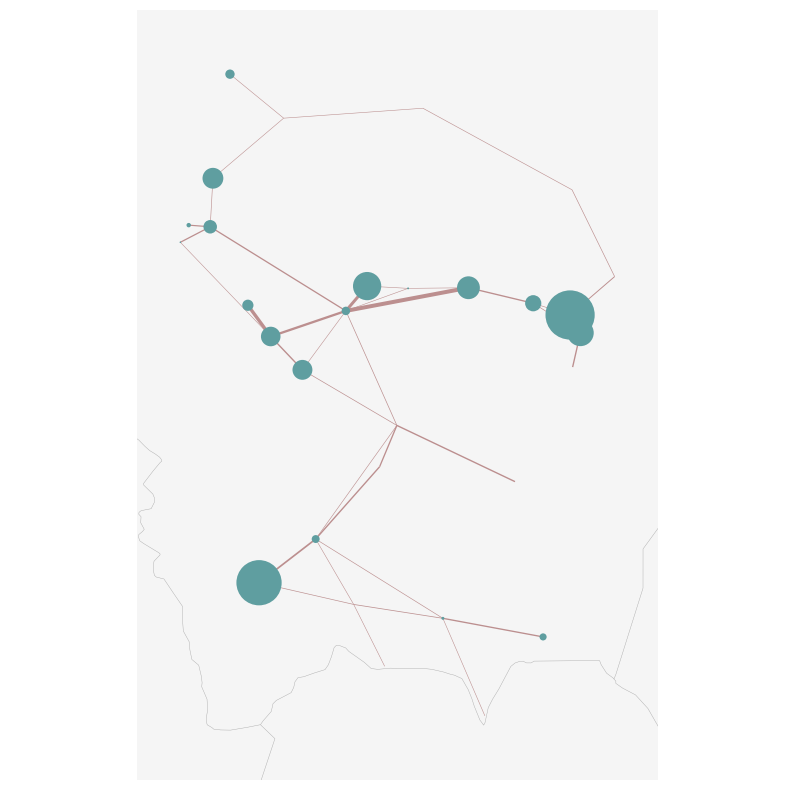

In [ ]:
import pypsa

network_fin = pypsa.Network('C:/Users/marih/OneDrive/Documents/pypsa-2802/pypsa-earth/base_nze_30_geo/BNZE30_2039.nc')

max_node_size = 0.1  # maximum size of a node for plotting purposes [used in plots]

def normalize_node_size(values, max_node_size=max_node_size):
    return values / values.max() * max_node_size

fig, ax = plt.subplots(
    figsize=(10, 10),
    subplot_kw={
        "projection": ccrs.PlateCarree()
    },  # PlateCarree(default), Mercator, Orthographic
)

n = network_fin


# Sum the power generation for each generator over all timesteps
total_generation = n.generators_t.p.sum()

# Create a DataFrame by merging total generation with bus IDs for each generator
gen_to_bus = pd.DataFrame({'generation': total_generation}).merge(n.generators[['bus']], left_index=True, right_on='Generator')

# Group by 'bus' and sum the generation, resulting in a Series
gen_per_bus = gen_to_bus.groupby('bus')['generation'].sum()


n.plot(
    margin=0.1,
    ax=None,
    geomap=True,  #'10m' leads to a beautiful high resolution map
    projection=None,
    bus_colors="cadetblue",
    bus_alpha=1,
    bus_sizes=normalize_node_size(
        gen_data_bus_reg
    ),
    bus_cmap=None,
    line_colors="rosybrown",
    link_colors="darkseagreen",  # loading
    transformer_colors="orange",
    line_widths=line_caps_fin / 3e2,
    link_widths=1.5,
    transformer_widths=1.5,
    line_cmap=None,
    link_cmap=None,  # plt.cm.virdis (colordmap for line loading)
    transformer_cmap=None,
    flow=None,
    branch_components=None,
    layouter=None,
    title="",
    boundaries=None,
    geometry=False,
    jitter=None,
    color_geomap=True,
)  # None or True

ax.axis("off")
plt.show()

In [ ]:
technologies_path = 'data_pypsa/technologies.xlsx'

# Load new technologies
new_techs_df = pd.read_excel(technologies_path, sheet_name='technologies_pypsa')
new_technologies = sorted(set(new_techs_df['New_names']))
 
# Map new technology names to old names for lookup
tech_name_map = new_techs_df.set_index('New_names')['Old_names'].to_dict()

# Remove spaces in tech_name_map keys
tech_name_map = {key.replace(" ", ""): value for key, value in tech_name_map.items()}

tech_name_map

{'Hydroregulated': 'hydro',
 'Hydrorun-of-the-river': 'ror',
 'GasOCGT': 'OCGT',
 'Bio': 'biomass',
 'GasCCGT': 'CCGT',
 'Oilexisting': 'oil',
 'Windonshore': 'onwind',
 'Solar': 'solar',
 'Geo': 'geothermal'}

In [ ]:
period = period_intervals[-1]

gen_p_nom = investment_data[(investment_data['Period'] == period)]
gen_p_nom = gen_p_nom[['Node', 'GeneratorType', 'genInstalledCap_MW']]

gen_p_nom['Node'] = gen_p_nom['Node'].str.replace(r'(BO)(\d{1})', r'\1\2 ', regex=True)

# Change GeneratorType names from EMPIRE names to PyPSA names using tech_name_map
gen_p_nom['GeneratorType'] = gen_p_nom['GeneratorType'].map(tech_name_map)

# Rename the GeneratorType column to carrier and the Node column to bus
gen_p_nom = gen_p_nom.rename(columns={'GeneratorType': 'carrier', 'Node': 'bus'})

# Rename the genInstalledCap_MW column to p_nom and the Generator column to index
gen_p_nom = gen_p_nom.rename(columns={'genInstalledCap_MW': 'p_nom'})

gen_p_nom = gen_p_nom.groupby(['bus', 'carrier']).sum()

gen_p_nom = gen_p_nom.squeeze()

gen_p_nom


bus    carrier
BO0 0  OCGT       3.916000e+01
       hydro      1.200000e+02
       onwind     9.498391e-15
       ror        7.540000e+00
       solar      8.870318e-14
                      ...     
BO0 8  oil        2.150000e+00
       onwind     2.363868e-14
       solar      3.946806e-14
BO0 9  onwind     2.130895e-14
       solar      4.691036e+02
Name: p_nom, Length: 90, dtype: float64

bus    carrier
BO0 0  OCGT       3.916000e+01
       hydro      1.200000e+02
       onwind     9.498391e-15
       ror        7.540000e+00
       solar      8.870318e-14
                      ...     
BO0 8  oil        2.150000e+00
       onwind     2.363868e-14
       solar      3.946806e-14
BO0 9  onwind     2.130895e-14
       solar      4.691036e+02
Name: p_nom, Length: 90, dtype: float64


c:\Users\marih\anaconda3\envs\pypsa-earth-20240127\lib\site-packages\cartopy\mpl\style.py:76: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '
c:\Users\marih\anaconda3\envs\pypsa-earth-20240127\lib\site-packages\cartopy\mpl\style.py:76: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '


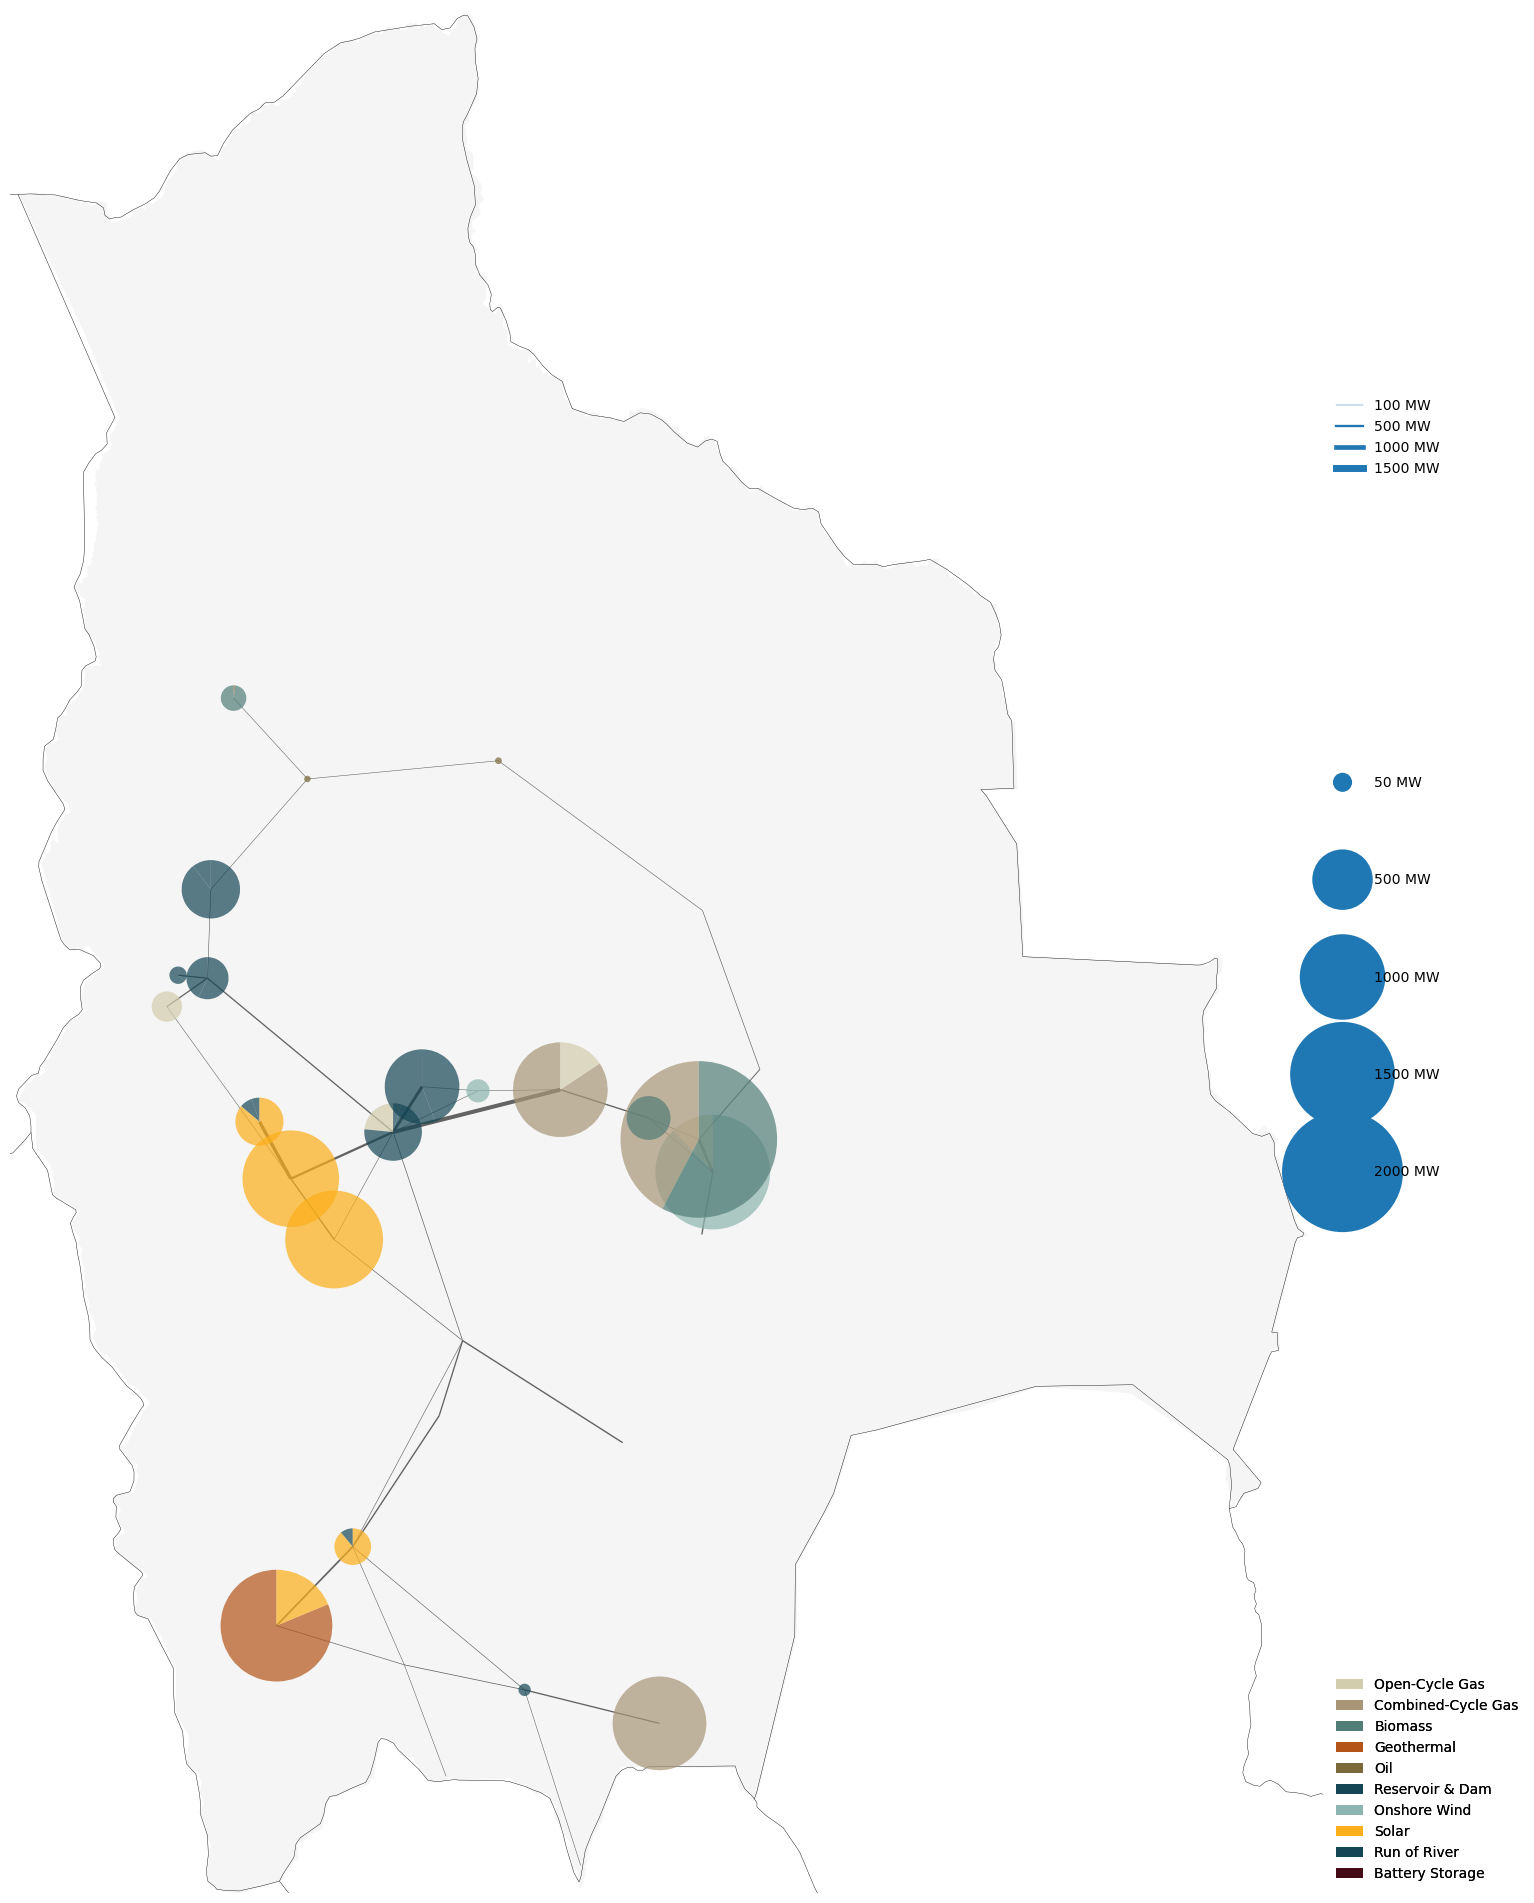

In [ ]:
bus_scale = 3e3 
line_scale = 3e2

import pypsa
import geopandas as gpd
from pypsa.plot import add_legend_circles, add_legend_lines, add_legend_patches
import matplotlib.pyplot as plt 
import cartopy.crs as ccrs

regions_onshore = gpd.read_file("c:/users/marih/OneDrive/Documents/pypsa-2802/pypsa-earth/resources/shapes/country_shapes.geojson")

carriers = n.carriers
carriers = n.carriers = n.carriers.drop(index='PHS')
carriers = n.carriers = n.carriers.drop(index='Load')
carriers_color = [beige3, beige2, teal3, brown2, beige1, teal2, teal4, yellow, teal2, brown]

n.carriers.color = carriers_color

fig, ax = plt.subplots(figsize=(15, 20), subplot_kw={"projection": ccrs.EqualEarth(n.buses.x.mean())})
gen = n.generators
gen = gen[~gen['carrier'].str.contains('load')]
gen = gen.groupby(["bus", "carrier"]).p_nom.sum()

sto = n.storage_units.groupby(["bus", "carrier"]).p_nom.sum()
buses = gen_p_nom #pd.concat([gen, sto])

print(buses)

bus_sizes = buses / bus_scale

with plt.rc_context({"patch.linewidth": 0.}):
    n.plot(
        bus_sizes=buses / bus_scale,
        bus_alpha=0.7,
        line_widths=line_caps_fin / line_scale,
        link_widths=n.links.p_nom / line_scale,
        line_colors='#636363'	,
        ax=ax,
        margin=0.2,
        color_geomap=None,
    )
regions_onshore.plot(
    ax=ax,
    facecolor="whitesmoke",
    edgecolor="white",
    aspect="equal",
    transform=ccrs.PlateCarree(),
    linewidth=0,
)
ax.set_extent(regions_onshore.total_bounds[[0, 2, 1, 3]])
legend_kwargs = {"loc": "upper left", "frameon": False}
# circles legend may requite some fine-tuning
legend_circles_dict = {"bbox_to_anchor": (1, 0.6), "labelspacing": 6, **legend_kwargs}
bus_sizes = [50, 500, 1000, 1500, 2000]  # in MW
line_sizes = [100, 500, 1000, 1500]  # in MW

add_legend_circles(
    ax,
    [s / bus_scale for s in bus_sizes],
    [f"{s} MW" for s in bus_sizes],
    legend_kw=legend_circles_dict,    
)
add_legend_lines(
    ax,
    [s / line_scale for s in line_sizes],
    [f"{s} MW" for s in line_sizes],
    legend_kw={"bbox_to_anchor": (1, 0.8), **legend_kwargs},
)
add_legend_patches(
    ax,
    n.carriers.color,
    n.carriers.nice_name,
    legend_kw={"bbox_to_anchor": (1, 0), **legend_kwargs, "loc":"lower left"},
)
fig.tight_layout()


